# Data Challenge - Bike Sharing Demand Prediction

As part of the course "Data science & Web Mining", you will be working on a regression problem. Specifically, you are given a dataset consisting of a few thousand records containing the hourly count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.
Your goal is to predict how many bikes will be rented each hour of a day, based on data including weather, time, temperature, whether or not its a workday, and much more.
The dataset was taken from UCI Machine Learning Repository.


## Dataset Information

Our training dataset contains information from 12,165 hours over 731 days with 14 features (information categories)  and 1 target for each hour.
The file named *train.csv* contains the training set of the problem, while the file *test.csv* contains the test set of the problem. Each line of these two files corresponds to a bike sharing record characterized by the following variables:

Variable | Description
--- | --- | ---
season | season (1:winter, 2:spring, 3:summer, 4:fall)
yr | year (0: 2011, 1:2012)
mnth | month (1 to 12)
hr | hour (0 to 23)
holiday | weather day is holiday or not
weekday|day of the week
workingday | if day is neither weekend nor holiday is 1, otherwise is 0.
weathersit | 1: Clear, Few clouds, Partly cloudy, Partly cloudy
| 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
| 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
| 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp | Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
atemp | Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
hum | Normalized humidity. The values are divided to 100 (max)
windspeed | Normalized wind speed. The values are divided to 67 (max)
casual | count of casual users
registered | count of registered users
cnt | count of total rental bikes including both casual and registered 

The training set contains the variable `cnt` which is related to the number of bicycles rented in any given 1 hour time-period. The `cnt` (and also `casual` and `registered` which obviously contain direct information about the bike sharing count) variable is missing from the test set as it is the variable to be predicted.

In [1]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

The code that loads the training data from file *train.csv* into a DataFrame of the Pandas library (https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html#overview) and prints the first 5 lines, is given below. So you can see the 15 variables of the problem.

In [2]:
# Reading training data from the local storage

filename = 'dataset/train.csv' 
df_train = pd.read_csv(filename)
df_train.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


Also, as for the dimensions of the training set, it consists of 12165 lines and 15 columns. That is, you have the data from 12165 bike sharing records for which you know the number of bicycles rented `cnt`
.

In [3]:
df_train.shape

(12165, 15)

Instead, the file named *test.csv* contains the test set of the problem. As with the training set, you are now given code that loads the test set into a DataFrame of the Pandas library and prints its first 5 lines.

In [4]:
df_test = pd.read_csv('dataset/test.csv')
df_test.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


As for the dimensions of the test set, as you can see below, it consists of 5214 lines and 12 columns. The missing columns is about the `cnt` variable you are aiming to predict.

In [5]:
df_test.shape

(5214, 12)

## Goal

As mentioned above, your goal is to predict the number of bicycles (variable `cnt`) rented for each 1 hour period-time of the test set. This is a supervised learning problem. You will need to preprocess the training set data, and then use it to train a regressor, which you will use to make predictions for the test set data.

## Evaluation - RMSLE Score

One common way to evaluate a regression model is through calculating Mean Squared Error (MSE) or Root Mean Squared Error (RMSE). 

$$ RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^N (\hat{y_i} - y_i)^2} $$

In this particular competition, the metric to evaluate your model is **Root Mean Square Logarithmic Error** (RMSLE). It is particularly helpful when we want to penalize an under-predicted estimate greater than an over-predicted estimate. If $\hat{y_i}$ is the predicted value of the $I$-th sample, and ${y_i}$ is the corresponding true value, then the RMSLE estimated over $N$ samples is defined as:

$$ RMSLE = \sqrt{\frac{1}{N} \sum_{i=1}^N (\log(1+\hat{y_i}) - \log(1+y_i))^2 } $$

## Initial Python Code

Check existence of null values in the dataset:

In [6]:
df_train.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

It seems that no null value is present in the dataset.

Lets change column names for a nice precise reading:

In [7]:
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

In [8]:
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


Check data type for each column:

In [9]:
df_train.dtypes

season          int64
year            int64
month           int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Some data types need to be changed from numerical to categorical in order for the model to interpret better these variables.

In [10]:
df_train['season'] = df_train.season.astype('category')
df_train['year'] = df_train.year.astype('category')
df_train['month'] = df_train.month.astype('category')
df_train['hour'] = df_train.hour.astype('category')
df_train['holiday'] = df_train.holiday.astype('category')
df_train['weekday'] = df_train.weekday.astype('category')
df_train['workingday'] = df_train.workingday.astype('category')
df_train['weather'] = df_train.weather.astype('category')

Lets confirm the converted data types:

In [11]:
df_train.dtypes

season        category
year          category
month         category
hour          category
holiday       category
weekday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity       float64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

###  Exploratory Data Analysis

Analyze the change in bike sharing pattern (`count` variable) with categorical variables:

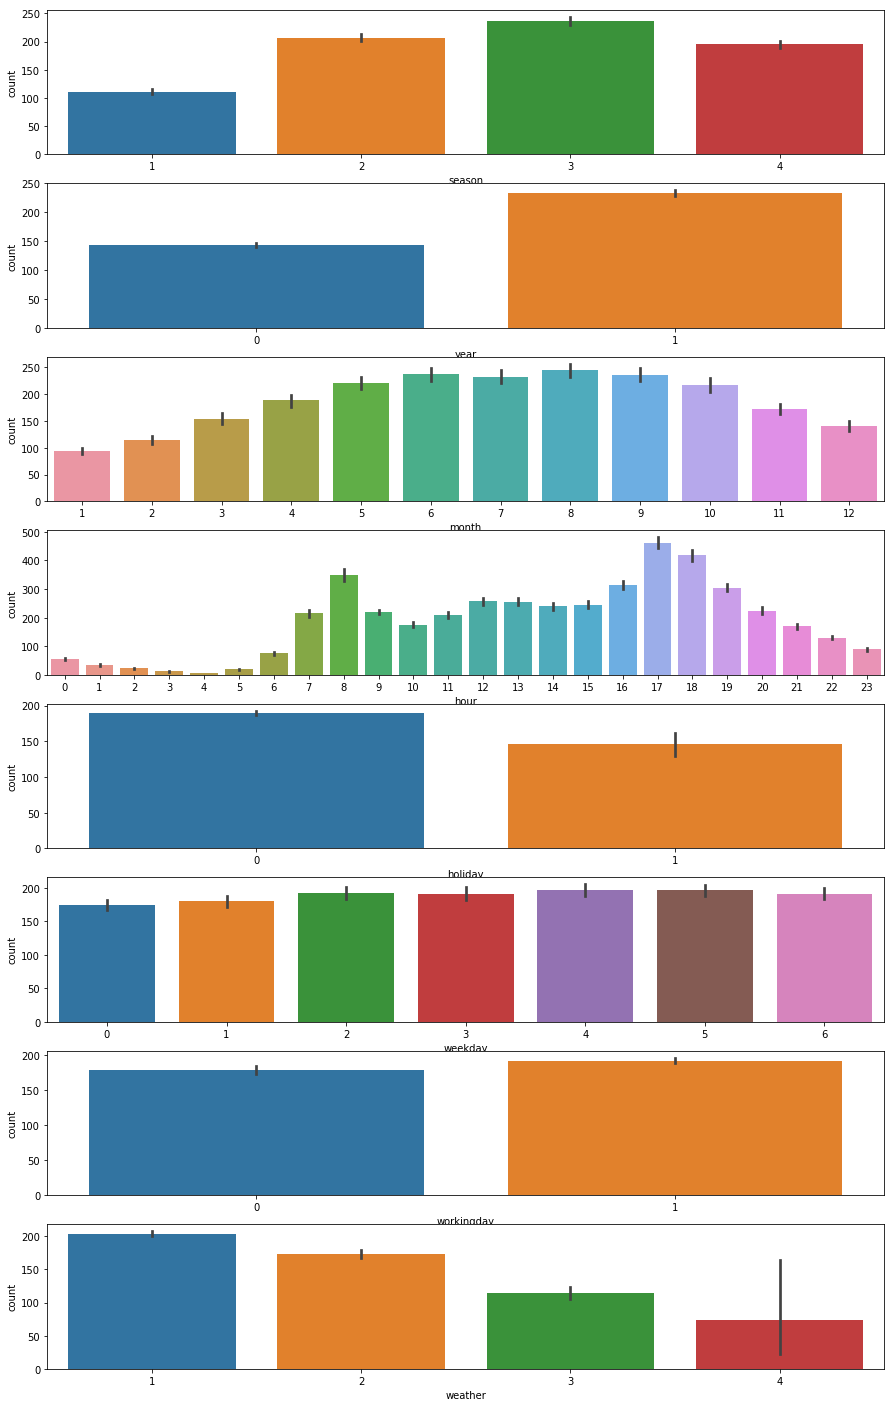

In [12]:
fig,[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8] = plt.subplots(nrows=8, figsize=(15,25))
sn.barplot(x = df_train['season'], y = df_train['count'],ax = ax1)
sn.barplot(x = df_train['year'], y = df_train['count'],ax = ax2)
sn.barplot(x = df_train['month'], y = df_train['count'],ax = ax3)
sn.barplot(x = df_train['hour'], y = df_train['count'],ax = ax4)
sn.barplot(x = df_train['holiday'], y = df_train['count'],ax = ax5)
sn.barplot(x = df_train['weekday'], y = df_train['count'],ax = ax6)
sn.barplot(x = df_train['workingday'], y = df_train['count'],ax = ax7)
sn.barplot(x = df_train['weather'], y = df_train['count'],ax = ax8)

It is evident that each of the above categorical variables have impact on `count` variable.

Analyze the change in bike sharing pattern (`count` variable in dataset) with numerical variables:

[Text(0.5, 1.0, 'Relation between windspeed and count')]

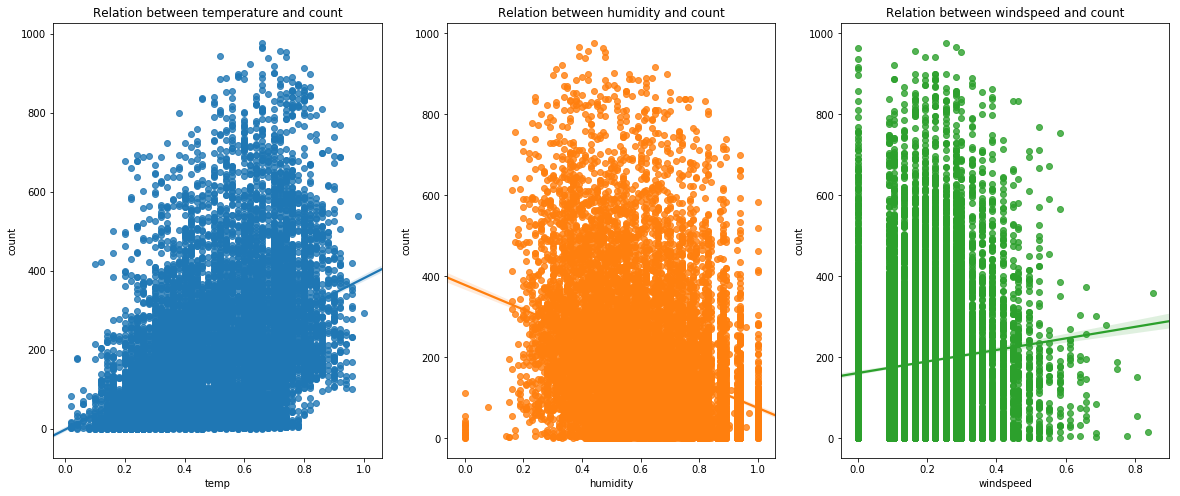

In [13]:
# Regression plot is used to verify if a pattern can be observed between `count` and numerical variables

fig,[ax1,ax2,ax3] = plt.subplots(ncols = 3, figsize = (20,8))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

sn.regplot(x = 'temp', y = 'count',data = df_train, ax = ax1)
ax1.set(title="Relation between temperature and count")
sn.regplot(x = 'humidity', y = 'count',data = df_train, ax = ax2)
ax2.set(title="Relation between humidity and count")
sn.regplot(x = 'windspeed', y = 'count',data = df_train, ax = ax3)
ax3.set(title="Relation between windspeed and count")

### Correlation Analysis

To see how numerical variables are connected with each other, data correlation can be checked:

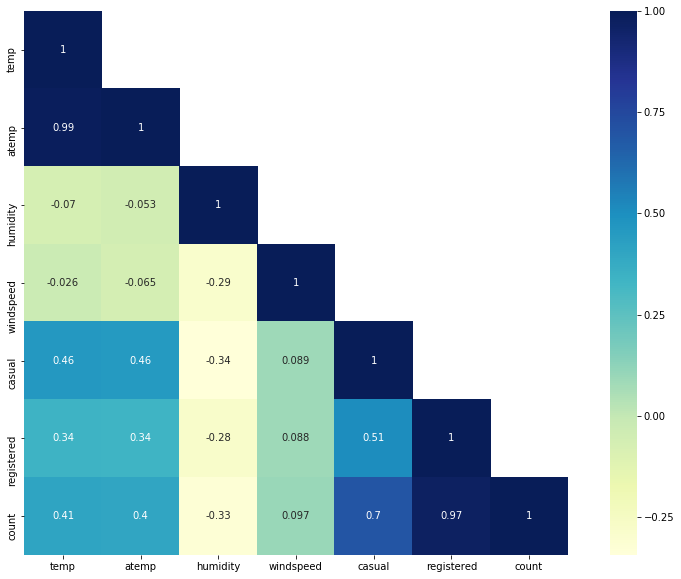

In [14]:
data_corr = df_train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
mask = np.array(data_corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(15, 10))
sn.heatmap(data_corr, mask=mask, vmax=1, square=True, annot=True, cmap="YlGnBu")

It can be observed that:
- `temp` and `atemp` are strongly correlated. To reduce the dimensionality of the predictive model, the feature `atemp` is dismissed.
- `casual` and `registered` contain direct information about the bike sharing `count` which we want to predict (data leakage). Therefore they are not considered in the feature set.
- `temp` has positive correlation and `humidity` has negative correlation with `count`.
- `windspeed` has little correlation with `count`.
- The variables `hour` and `temp` seem to be promising features for the bike sharing count prediction.

In [15]:
df_train = df_train.drop(['atemp', 'casual', 'registered', 'windspeed'], axis=1)

In [16]:
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,humidity,count
0,4,0,11,0,0,2,1,1,0.56,0.64,22
1,1,0,2,21,0,6,0,1,0.28,0.65,68
2,4,1,11,12,0,3,1,1,0.44,0.41,344
3,1,1,1,7,0,2,1,2,0.18,0.93,222
4,1,1,3,16,0,1,1,1,0.30,0.45,210


# Model building

Here we use only 3 features `temp`, `humidity`, `workingday` and a simple [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model. We also split our data into a training and test set to have a local evaluation:

In [17]:
# Training and test data is created by splitting the main data. 30% of test data is considered
X = df_train[['temp', 'humidity', 'workingday']]
y = df_train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
X_train.shape

(8515, 3)

In [19]:
y_train.shape

(8515,)

Create a linear regression object and train the model using the training set:

In [20]:
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Make predictions using the testing set:

In [21]:
y_pred = clf.predict(X_test)

In [22]:
True in (y_pred < 0)

True

We observe that there are negative predictions. It has no physical meaning, and in order to be able to use RMSLE score  we convert these values to zero:

In [23]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

We check RMSLE and R-square scores. The R-square value is also very reasonable for this dataset which has a huge number of outliers.

In [24]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

RMSLE: 1.4089269914543352
R2: 0.2623846254013368


To understand the performance of the model, a regression plot can be drawn between actual and predicted data. Bins are   used to make the pattern more meaningful.

[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

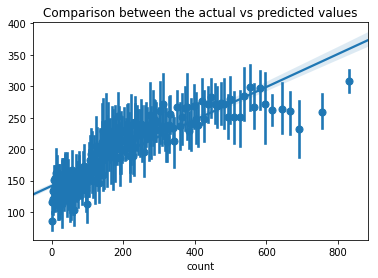

In [25]:
ax = sn.regplot(y_test, y_pred, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

From the plot it is visible that the deviations from actual test data are very high and not restricted in a limit. Maybe outliers have great negative impact in models' performance. So we must search for better solutions.

# Kaggle Submission

Now we will use the fitted model to make predictions for the **given** test set. First we load the test set and then follow the same preprocessing steps as for train set.

In [26]:
filename = 'dataset/test.csv' 
df_test = pd.read_csv(filename)
df_test.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


In [27]:
df_test.shape

(5214, 12)

In [28]:
df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

In [29]:
df_test['season'] = df_test.season.astype('category')
df_test['year'] = df_test.year.astype('category')
df_test['month'] = df_test.month.astype('category')
df_test['hour'] = df_test.hour.astype('category')
df_test['holiday'] = df_test.holiday.astype('category')
df_test['weekday'] = df_test.weekday.astype('category')
df_test['workingday'] = df_test.workingday.astype('category')
df_test['weather'] = df_test.weather.astype('category')

In [30]:
df_test = df_test.drop(['atemp', 'windspeed'], axis=1)

In [31]:
df_test = df_test[['temp', 'humidity', 'workingday']]

In [32]:
df_test.shape

(5214, 3)

In [33]:
y_pred = clf.predict(df_test)

In [34]:
True in (y_pred < 0)

True

Convert these values to zero:

In [35]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

Prepare a pandas dataframe according to submission format and save it to `submission.csv`:

In [36]:
submission = pd.DataFrame()
submission['Id'] = range(y_pred.shape[0])
submission['Predicted'] = y_pred

In [37]:
submission.to_csv("submission.csv", index=False)

Now we can upload our submission to Kaggle platform, which gives us a score `1.37116`

**`Note:`**
In the above example we splitted the given train set (X, y) to train and test sets to have a better view in our models' performance. After fine-tuning models' parameters we need to train our model in whole train set.

# Ideas for improving the model

For any ML project, preprocessing the data is a crucial step. The process is usually an accumulation of widely followed pre-processing practices, and case-specific tweaks made to the data based on judgement-calls from the person designing the models. If data-wrangling is done incorrectly or inadequately, it can lead to ill-trained ML algorithms that provide inaccurate or (at best) sub-optimal results. The age-old saying, “Garbage in, Garbage out” applies here. An important part of this process is **Feature Engineering**, which involves turning available data features into more useful variables that can help us predict our outcome.

So here we propose some ideas to improve your model:

- Train including all features.
- Use one-hot encoding technique. Since we have categorical values in our data set, we need to ‘tell’ our algorithm that classes have equal weight for our analysis. By one-hot encoding, we convert non-binary categorical features (like 'season', 'year', 'month', etc) into multiple binary sub-features where each sub-feature indicates whether a certain category for the original feature is True or Not (1 or 0).
- Use Cross-validation to evaluate your estimators' performance, avoid overfitting and achieve good generalization.
- Use GridSearchCV to tune your estimator by testing different parameters.
- Use prior knowledge to remove features that don’t add important information.
- Use regularization (L1 & L2).
- Try ensemble models.
- Predict casual and registered user count separately.
- Search for outliers' impact.
- Make use of time series analysis.

# Project submission

The project is either individual or can be done in groups of up to 3 people. The final evaluation will be based both on the RMSLE score you achieve and your overall approach to the problem. As part of the project, the following should be submitted:
- A 2-page report describing the approach and methods you used. Since this is a real regression problem, we are interested in knowing how you dealt with each stage of the problem, e.g. what kind of data representation you used, what features you used, if you applied dimensionality reduction techniques, what algorithms you tried and why, the performance of your methods (RMSLE score and training time), any approaches that ultimately didn't work but are interesting to present, and generally, whatever you think is interesting to mention.
- A folder with your code.
- Alternatively you can combine the two above into one Ipython Notebook file.
- Create a .zip file containing the code and report and submit it to the e-class platform, indicating also your Kaggle TeamName.

**End date**: 26 December 2019.


--------------------------------

# One-hot encoding example with pandas

Here we show one-hot encoding of the 2 categorical variables `A` and `B` of dataframe `df` using [`pandas.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)

In [38]:
df = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['1', '2', '3'], 'C': [1, 2, 3]})

In [39]:
df

,A,B,C
0,a,1,1
1,b,2,2
2,a,3,3


In [40]:
pd.get_dummies(df)

,C,A_a,A_b,B_1,B_2,B_3
0,1,1,0,1,0,0
1,2,0,1,0,1,0
2,3,1,0,0,0,1
